In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [2]:
img_dir = '../GTEA_gaze_part/data/Images/'
mask_dir = '../GTEA_gaze_part/data/Masks_255/'
split_folder = '../split_data/'

In [3]:
if os.path.exists(split_folder)==False:
    os.mkdir(split_folder)
else:
    print('{} already exists'.format(split_folder))

../split_data/ already exists


In [4]:

split_data = False
split_img = False
split_mask = False
if split_data == True and split_img==False:
    split_folders.ratio(img_dir, output= split_folder, seed=1337, ratio=(.8, .1, .1))
    split_img = True
train_mask = split_folder + 'train_mask/'
test_mask = split_folder + 'test_mask/'
val_mask = split_folder + 'val_mask/'
if split_data==True and split_img ==True and split_mask==False:
    if os.path.exists(train_mask)==False:
        os.mkdir(train_mask)
        os.mkdir(train_mask +'/hands')
    else:
        print('{} already exists'.format(train_mask))
    if os.path.exists(test_mask)==False:
        os.mkdir(test_mask)
        os.mkdir(test_mask +'/hands')
    else:
        print('{} already exists'.format(test_mask))
    if os.path.exists(val_mask)==False:
        os.mkdir(val_mask)
        os.mkdir(val_mask +'/hands')
    else:
        print('{} already exists'.format(val_mask))
    data_categories = [('train/hands', train_mask +'/hands/' ),('test/hands', test_mask+'/hands/'),('val/hands', val_mask+'/hands/')]
    for (img_fold, mask_fold) in data_categories:
        for filename in glob(split_folder + img_fold + '/*.jpg'):
            shutil.copyfile((mask_dir + filename.split("/")[-1].split(".jpg")[0] +'.png'), mask_fold + filename.split("/")[-1].split(".jpg")[0] +'.png')
    

In [5]:
x_train_dir = os.path.join(split_folder, 'train')
y_train_dir = train_mask

x_test_dir = os.path.join(split_folder, 'test')
y_test_dir = test_mask

x_val_dir = os.path.join(split_folder, 'val')
y_val_dir = val_mask

print(x_train_dir, y_train_dir, x_test_dir, y_test_dir, x_val_dir, y_val_dir)

../split_data/train ../split_data/train_mask/ ../split_data/test ../split_data/test_mask/ ../split_data/val ../split_data/val_mask/


In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:


from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset



In [8]:
    
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['hands']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = []
        
        for cls in classes:
            self.ids.extend(glob(os.path.join(images_dir,cls) + '/*'))
        self.images_fps = self.ids
        self.masks_fps = []
        for cls in classes:
            self.masks_fps = [os.path.join(masks_dir,cls, image_id.split('/')[-1].split('.jpg')[0] + '.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
#         print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (320,320))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (320,320))
        mask = cv2.bitwise_not(mask)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
#         print(mask.shape)
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
#         print("image sizes", image.shape, mask.shape)
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    


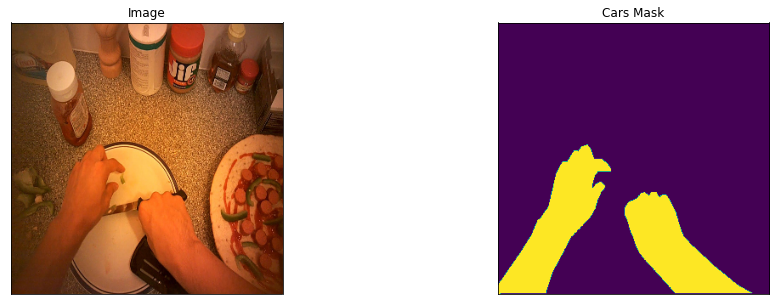

In [9]:


# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['hands'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)


In [10]:
import albumentations as albu

In [35]:
!which python

In [36]:
!pip install albumentations

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

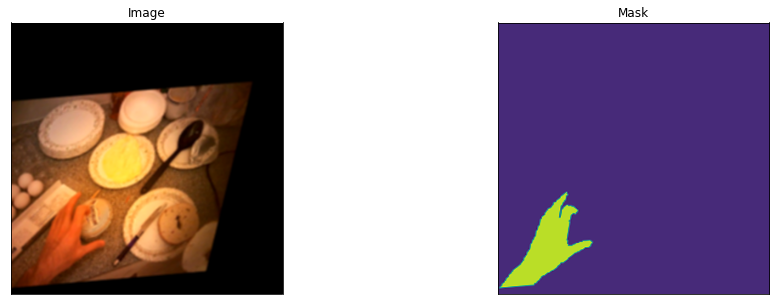

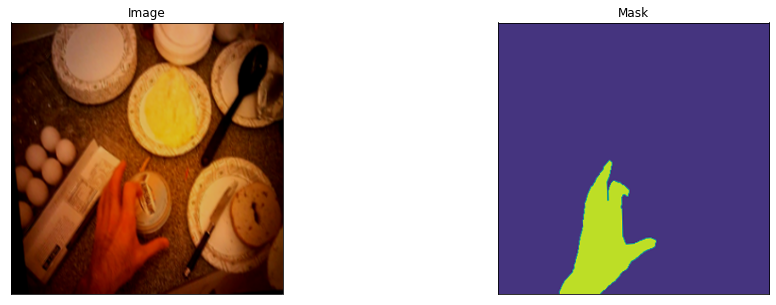

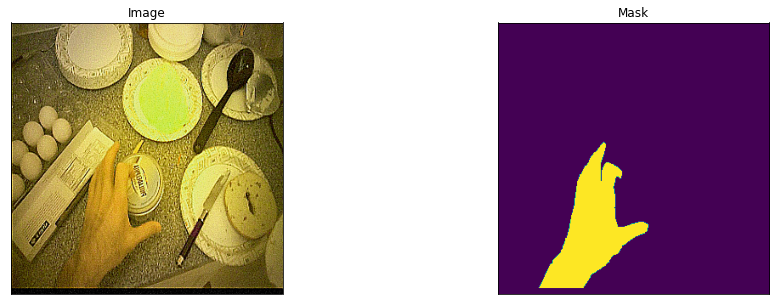

In [12]:


#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['hands'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))



# Create Model and train

In [13]:
!pip install segmentation_models_pytorch

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [15]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['hands']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['hands']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [20]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [21]:


# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])



In [22]:


# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)



In [49]:


# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')




Epoch: 0
valid: 100%|██████████| 111/111 [00:02<00:00, 49.86it/s, dice_loss - 0.1247, iou_score - 0.8576]
Model saved!

Epoch: 1
valid: 100%|██████████| 111/111 [00:02<00:00, 48.17it/s, dice_loss - 0.1051, iou_score - 0.8742]
Model saved!

Epoch: 2
valid: 100%|██████████| 111/111 [00:02<00:00, 48.64it/s, dice_loss - 0.09583, iou_score - 0.8772]
Model saved!

Epoch: 3
valid: 100%|██████████| 111/111 [00:02<00:00, 47.68it/s, dice_loss - 0.08642, iou_score - 0.8804]
Model saved!

Epoch: 4
valid: 100%|██████████| 111/111 [00:02<00:00, 46.45it/s, dice_loss - 0.0876, iou_score - 0.8755] 

Epoch: 5
valid: 100%|██████████| 111/111 [00:02<00:00, 45.54it/s, dice_loss - 0.08132, iou_score - 0.8781]

Epoch: 6
valid: 100%|██████████| 111/111 [00:02<00:00, 45.38it/s, dice_loss - 0.06828, iou_score - 0.8966]
Model saved!

Epoch: 7
valid: 100%|██████████| 111/111 [00:02<00:00, 45.58it/s, dice_loss - 0.07129, iou_score - 0.8908]

Epoch: 8
valid: 100%|██████████| 111/111 [00:02<00:00, 44.72it/s, dice_l

# Test best saved model

In [14]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [19]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [44]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 112/112 [00:05<00:00, 21.98it/s, dice_loss - 0.1797, iou_score - 0.8746]
